In [19]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as thdat
import seaborn as sns
from tqdm import tqdm


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#sns.set_theme()
torch.manual_seed(42)


In [20]:
data = pd.read_csv('/Users/kanha/pinns/Data/newtons_cooling_obs.csv')
data_soln = pd.read_csv('/Users/kanha/pinns/Data/newtons_cooling_exact.csv')

x_data_orig = data["Times"]
y_data_orig = data["Temperature"]

x_data_soln = data_soln["Times"]
y_data_soln = data_soln["Temperature"]

X_data = torch.tensor(x_data_orig, dtype=torch.float32).reshape(-1, 1)
Y_data = torch.tensor(y_data_orig, dtype=torch.float32).reshape(-1, 1)

X_data_eqn = torch.tensor(x_data_soln, dtype=torch.float32).reshape(-1, 1)
Y_data_eqn = torch.tensor(y_data_soln, dtype=torch.float32).reshape(-1, 1)

print(X_data.shape, Y_data.shape)
print(X_data_eqn.shape, Y_data_eqn.shape)

torch.Size([10, 1]) torch.Size([10, 1])
torch.Size([1000, 1]) torch.Size([1000, 1])


#### Loss function

To simulate the system, the PINN is trained with the following loss function:
#### Boundary condition loss + Physics loss + Data loss
$$
\mathcal{L}(\theta)= (u_{\mathrm{PINN}}(t=0;\theta) - 1)^2 + \lambda_1 \left(\frac{d\,u_{\mathrm{PINN}}}{dt}(t=0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2 + \frac{\lambda}{M} \sum^{M}_{j} \left( u_{\mathrm{PINN}}(t_{j};\theta) - u_{\mathrm{obs}}(t_{j}) \right)^2
$$

#### Notes

There are two terms in the loss function here. The first is the **physics loss**, formed in the same way as above, which ensures the solution learned by the PINN is consistent with the know physics.

The second term is called the **data loss**, and makes sure that the solution learned by the PINN fits the (potentially noisy) observations of the solution that are available.

In [27]:
from torch import nn

class MLP_direct(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layers = nn.Sequential(
                          nn.Linear(1, 100),
                          nn.ReLU(),
                          nn.Linear(100, 50),
                          nn.ReLU(),
                          nn.Linear(50, 1)
                        )


    def forward(self, x):
        out = self.layers(x)
        return out

In [ ]:

def oscillator(x, w0, d):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = torch.sqrt(w0**2-d**2)
    phi = torch.arctan(-d/w)
    A = 1/(2*torch.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y


targets = Y_data 
x_steps = X_data
inputs = X_data

# Initialize the MLP
torch.random.manual_seed(3)
mlp = MLP_direct()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

# Run the training loop
losses = []
pred_w0 = []
pred_d = []
pred_r = []
final_pred = []

for epoch in tqdm(range(5)): 

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass to get drift
    full_output = mlp(inputs)
    #print("inputs: ", inputs)
    print("Full output: ", full_output)
    print("Targets:", targets)
    
    #w0_nn = full_output[:, 0]
    #d_nn = full_output[:, 1]
    #t0_nn = full_output[:, 0]
    #r_nn = full_output[:, 0]
    #print(r_nn)
    #print(type(Tenv))
    #print(type(r_nn))
    #print(type(t0_nn))
    #print(type(x_steps))
    # Propagate drift through to end position
    #pred = oscillator(x_steps, w0_nn, d_nn)[:,None]
    #pred = cooling_law(x_steps, Tenv, T0, r_nn)[:,None]
    #pred = position(t_end, a, x0_start+x0_drift, v0_start+v0_drift)[:, None]

    # Compute loss
    loss = loss_fn(full_output - targets)
    #loss = loss_fn(pred, targets)

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()
    
    losses.append(loss.item())
    #pred_w0.append(t0_nn.flatten().clone().detach())
    pred_r.append(r_nn.flatten().clone().detach())
    final_pred.append(pred.flatten().clone().detach())
    

In [55]:

def oscillator(x, w0, d):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    #print("d:", d)
    #print("W0", w0)
    #assert d < w0
    #d = d.detach().numpy()
    #w0 = w0.detach().numpy()
    #x = x.detach().numpy()
    w = torch.sqrt(w0**2-d**2)
    phi = torch.arctan(-d/w)
    A = 1/(2*torch.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y


def cooling_law(time, Tenv, T0, R):
    T = Tenv + (T0 - Tenv) * torch.exp(-R * time)
    return T

#Tenv = 25
Tenv = torch.tensor(25.)
T0 = torch.tensor(100.)
targets = Y_data 
x_steps = X_data
inputs = X_data

# Initialize the MLP
torch.random.manual_seed(3)
mlp = MLP_direct()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-2)

# Run the training loop
losses = []
pred_w0 = []
pred_d = []
pred_r = []
final_pred = []

for epoch in tqdm(range(10000)): 

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass to get drift
    full_output = mlp(inputs)
    #print("inputs: ", inputs)
    #print("Full output: ", full_output)
    #print("Targets:", targets)
    
    #w0_nn = full_output[:, 0]
    #d_nn = full_output[:, 1]
    #t0_nn = full_output[:, 0]
    #r_nn = full_output[:, 0]
    #print(r_nn)
    #print(type(Tenv))
    #print(type(r_nn))
    #print(type(t0_nn))
    #print(type(x_steps))
    # Propagate drift through to end position
    #pred = oscillator(x_steps, w0_nn, d_nn)[:,None]
    #pred = cooling_law(x_steps, Tenv, T0, r_nn)[:,None]
    #pred = position(t_end, a, x0_start+x0_drift, v0_start+v0_drift)[:, None]

    # Compute loss
    loss = ((full_output - targets)**2).mean()
    #loss = loss_fn(full_output - targets)
    #loss = loss_fn(pred, targets)

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()
    
    losses.append(loss.item())
    #pred_w0.append(t0_nn.flatten().clone().detach())
    pred_r.append(r_nn.flatten().clone().detach())
    final_pred.append(pred.flatten().clone().detach())
    

100%|██████████| 10000/10000 [00:07<00:00, 1260.83it/s]


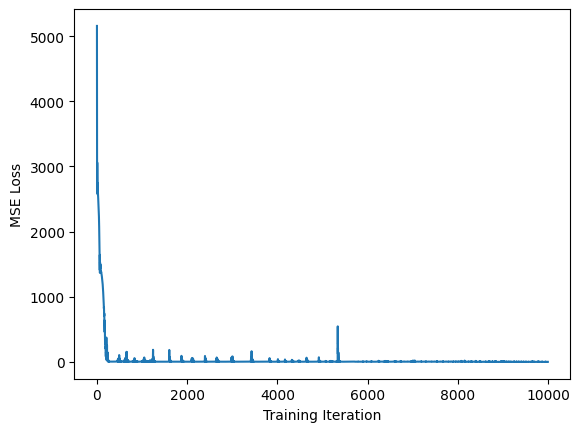

In [56]:
plt.plot(losses)
plt.xlabel('Training Iteration')
plt.ylabel('MSE Loss')
plt.show()

In [57]:
full_output

tensor([[106.2765],
        [ 91.8688],
        [ 71.5713],
        [ 70.4672],
        [ 66.7482],
        [ 56.5657],
        [ 53.1233],
        [ 49.6809],
        [ 46.2385],
        [ 42.7960]], grad_fn=<AddmmBackward0>)

In [58]:
y_data_soln[:10]

0    100.000000
1     99.625562
2     99.252994
3     98.882286
4     98.513429
5     98.146413
6     97.781229
7     97.417869
8     97.056323
9     96.696581
Name: Temperature, dtype: float64

In [32]:
plt.hist(pred_w0[-1])
plt.show()

IndexError: list index out of range

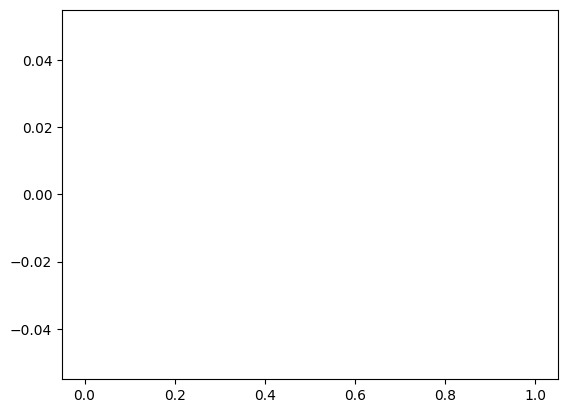

In [33]:
plt.hist(pred_r)
plt.show()

In [26]:
plt.plot(inputs, final_pred[-1], c='r', label='Fit')
plt.plot(inputs, targets, c='k', label='True')
plt.legend()
plt.xlabel('Launch Time')
plt.ylabel('End Position')
plt.show()

IndexError: list index out of range

In [ ]:
print(pred_r)